In [ ]:
# read in the geotiff with rasterio
# copy the channel as 3 channels, 
# make a png

## conver the tif files to png, this code sort the scaling, tried imagemagick convert but it the images were all black

In [6]:
import rasterio
import matplotlib.pyplot as plt 
import scipy.misc
import numpy as np

In [71]:

count = 0

root_folder = '/home/ubuntu/data/sar/train/train_3classes_240/other/'
for filename in os.listdir (root_folder):
    data_path = os.path.join(root_folder, filename)

    with rasterio.open(data_path) as raster:
        img_array = raster.read(1)
    count +=1
#     plt.imshow(img_array)
#     plt.show()
    png_path = data_path.replace('.tif', '.png')
    scipy.misc.imsave(png_path, img_array)
    
print(count)

2533


In [31]:
# # used to make the validation data - commented so do not run again. 

import glob
from shutil import move
from shutil import copyfile

%cd /home/ubuntu/data/sar/train/train_3classes_140/oil_platform/ 
g = glob.glob('*.png')
shuf = np.random.permutation(g)
for i in range(30): copyfile(shuf[i], '/home/ubuntu/data/sar/train/sample_240/valid/' +'/turbine/' + shuf[i])
# for i in range(200): move(shuf[i], '/home/ubuntu/data/sar/train/valid_3classes_140' +'/oil_platform/' + shuf[i])


/home/ubuntu/data/sar/train/train_3classes_140/oil_platform


manually removed the following files to make the numbers nicer for the batching 
S1A_IW_GRDH_1SDV_20170214T062124_20170214T062149_015276_019087_AF6B_terrain_correction_9.png            
S1A_IW_GRDH_1SDV_20170214T062124_20170214T062149_015276_019087_AF6B_terrain_correction_9_rot180.png     
S1A_IW_GRDH_1SDV_20170214T062124_20170214T062149_015276_019087_AF6B_terrain_correction_9_rot90.png

## get the base model of vgg and precompute the convolutional layers

In [16]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Flatten
import numpy as np
from keras.utils.np_utils import to_categorical

base_model = VGG16(weights='imagenet', include_top=False)


Using TensorFlow backend.


In [17]:
for l in base_model.layers:
    l.trainable =False
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [18]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
#     rescale=1./255)
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
        '/home/ubuntu/data/sar/train/train_3classes_240',
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')


validation_generator = test_datagen.flow_from_directory(
        '/home/ubuntu/data/sar/train/valid_3classes_240', 
        target_size=(224, 224),
        shuffle=False,
        batch_size=10,
        class_mode='categorical')


Found 4420 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [4]:
train_generator.next.im_self.color_mode

'rgb'

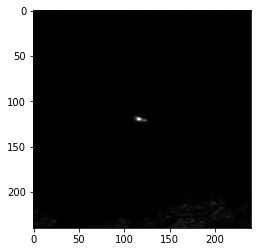

In [7]:
import cv2

img = cv2.imread('/home/ubuntu/data/sar/train/valid_3classes_240/other/S1A_IW_GRDH_1SDV_20170214T062124_20170214T062149_015276_019087_AF6B_terrain_correction_2.png')

plt.imshow(img)
plt.show()

In [15]:
img.shape

(240, 240, 3)

In [6]:
from keras.preprocessing.image import ImageDataGenerator
def preprocess_input(x, data_format=None):
    """Preprocesses a tensor encoding a batch of images.
    # Arguments
        x: input Numpy tensor, 4D.
        data_format: data format of the image tensor.
    # Returns
        Preprocessed tensor.
    """

    # 'RGB'->'BGR'
    x = x[:, :, ::-1]
    # Zero-center by mean pixel
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

In [9]:

def create_precomputed_data(model, batches):
    filenames = batches.filenames
    conv_features = model.predict_generator(batches, (batches.samples / batches.batch_size), verbose=1)
    labels_onehot = to_categorical(batches.classes)
    labels = batches.classes
    return (filenames, conv_features, labels_onehot, labels)



In [12]:
trn_filenames, trn_conv_features, trn_labels, trn_labels_1 = create_precomputed_data(base_model, train_generator)
val_filenames, val_conv_features, val_labels, val_labels_1 = create_precomputed_data(base_model, validation_generator)


60/60 [==============================] - 488s   


In [13]:
trn_conv_features.shape

(4420, 7, 7, 512)

In [14]:
RESULTS_DIR = '/home/ubuntu/data/sar/train/results'

In [15]:
import bcolz
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

def save_precomputed_data(filenames, conv_feats, labels, features_base_name="VGG240crops_conv_feats/trn_"):
    save_array(RESULTS_DIR+"/"+features_base_name+'filenames.dat', np.array(filenames))
    save_array(RESULTS_DIR+"/"+features_base_name+'conv_feats.dat', conv_feats)
    save_array(RESULTS_DIR+"/"+features_base_name+'labels.dat', np.array(labels))
    
save_precomputed_data(trn_filenames, trn_conv_features, trn_labels, "VGG240crops_conv_feats/trn_")
save_precomputed_data(val_filenames, val_conv_features, val_labels, "VGG240crops_conv_feats/val_")



In [ ]:
import bcolz
def load_array(fname):
    return bcolz.open(fname)[:]

def load_precomputed_data(features_base_name="VGG240crops_conv_feats/trn_"):
    filenames = load_array(RESULTS_DIR+"/"+features_base_name+'filenames.dat').tolist()
    conv_feats = load_array(RESULTS_DIR+"/"+features_base_name+'conv_feats.dat')
    labels = load_array(RESULTS_DIR+"/"+features_base_name+'labels.dat')
    return filenames, conv_feats, labels

trn_filenames, trn_conv_features, trn_labels = load_precomputed_data("VGG240crops_conv_feats/trn_")
val_filenames, val_conv_features, val_labels = load_precomputed_data("VGG240crops_conv_feats/val_")



In [19]:
from keras.layers import Input, BatchNormalization, Dense, Dropout, Conv2D
from keras.layers import MaxPooling2D, GlobalAveragePooling2D, Activation
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from datetime import datetime
import distutils.dir_util
from keras.callbacks import CSVLogger

p=0.7
classifier_input_shape = (7, 7, 512)
# classifier_input_shape = resnet_base.layers[-1].output_shape[1:]
classifier_input = Input(shape=classifier_input_shape)

# Create classifier model
      
x = Flatten()(classifier_input)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(3, activation='softmax')(x)
                                                     
classifier_model_v1 = Model(classifier_input, x)

#from keras.optimizers import SGD
classifier_model_v1.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])



In [22]:
classifier_model_v1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 25088)             100352    
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               12845568  
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

In [17]:
def fit_precomputed_helper(model, result_dir_name, lr=0.1, nb_epoch=1):  
    K.set_value(model.optimizer.lr, lr)
    
    now = datetime.now().strftime("%Y%m%d_%H%M%S.h5")
    results_dir = RESULTS_DIR + "/" + result_dir_name + "/"
    distutils.dir_util.mkpath(results_dir)
    
    model.fit(trn_conv_features, trn_labels,
              batch_size=32, 
              epochs=nb_epoch,
              validation_data=(val_conv_features, val_labels),
              shuffle=True, 
              callbacks=[CSVLogger(results_dir+"epoch_results.csv", separator=',', append=True)])
    model.save_weights(results_dir + now)
    return model

In [19]:
classifier_model_v1 = fit_precomputed_helper(classifier_model_v1, "classifier_model_v1", lr=0.0001, nb_epoch=10)

Train on 4420 samples, validate on 600 samples
Epoch 1/10
3264/4420 [=====================>........] - ETA: 8s - loss: 1.8236 - acc: 0.3928

KeyboardInterrupt: 

In [ ]:
classifier_model_v1.save_weights('/home/ubuntu/git/learningWithKaggle/weights/fishing/ft_resnet93_valid.h5')

In [34]:
nf = 128
p = 0.4

# x = Flatten(input_shape=classifier_input_shape)(classifier_input)
x = Conv2D(nf,(3,3), activation='relu', padding='same')(classifier_input)
x = BatchNormalization(axis=1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(nf,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=1)(x)
x = MaxPooling2D()(x)
x = Conv2D(nf,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=1)(x)
# x = MaxPooling2D((1,2))(x)
x = Conv2D(3,(3,3), padding='same')(x)
x = Dropout(p)(x)
x = GlobalAveragePooling2D()(x)
x = Activation('softmax')(x)

classifier_model_v2 = Model(classifier_input, x)

classifier_model_v2.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [35]:
classifier_model_v2 = fit_precomputed_helper(classifier_model_v2, "classifier_model_v2", lr=0.0001, nb_epoch=10)

Train on 4420 samples, validate on 600 samples
Epoch 1/10
4420/4420 [==============================] - 28s - loss: 1.0589 - acc: 0.4613 - val_loss: 1.1881 - val_acc: 0.3167
Epoch 2/10
4420/4420 [==============================] - 28s - loss: 1.0341 - acc: 0.4729 - val_loss: 1.1866 - val_acc: 0.3350
Epoch 3/10
4420/4420 [==============================] - 28s - loss: 1.0287 - acc: 0.4756 - val_loss: 1.1648 - val_acc: 0.3333
Epoch 4/10
4420/4420 [==============================] - 28s - loss: 1.0045 - acc: 0.4837 - val_loss: 1.1489 - val_acc: 0.3300
Epoch 5/10
4420/4420 [==============================] - 28s - loss: 0.9806 - acc: 0.5104 - val_loss: 1.2446 - val_acc: 0.3283
Epoch 6/10
4420/4420 [==============================] - 28s - loss: 0.9262 - acc: 0.5369 - val_loss: 1.2550 - val_acc: 0.3283
Epoch 7/10
4420/4420 [==============================] - 28s - loss: 0.8726 - acc: 0.5622 - val_loss: 1.2657 - val_acc: 0.3367
Epoch 8/10
4420/4420 [==============================] - 28s - loss: 0.8

In [20]:
# Create classifier model

x= Flatten()(classifier_input)
x = Dense(3, activation='softmax')(x)
                                                     
classifier_model_v3 = Model(classifier_input, x)

#from keras.optimizers import SGD
classifier_model_v3.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
classifier_model_v3 = fit_precomputed_helper(classifier_model_v3, "classifier_model_v3", lr=0.001, nb_epoch=50)

Train on 4420 samples, validate on 600 samples
Epoch 1/50
4420/4420 [==============================] - 0s - loss: 1.0087 - acc: 0.7586 - val_loss: 4.8310 - val_acc: 0.2433
Epoch 2/50
4420/4420 [==============================] - 0s - loss: 0.8931 - acc: 0.7792 - val_loss: 6.3098 - val_acc: 0.2933
Epoch 3/50
4420/4420 [==============================] - 0s - loss: 1.6226 - acc: 0.7471 - val_loss: 3.9133 - val_acc: 0.2950
Epoch 4/50
4420/4420 [==============================] - 0s - loss: 1.4037 - acc: 0.7817 - val_loss: 4.8687 - val_acc: 0.2533
Epoch 5/50
4420/4420 [==============================] - 0s - loss: 0.9947 - acc: 0.7803 - val_loss: 5.9887 - val_acc: 0.2283
Epoch 6/50
4420/4420 [==============================] - 0s - loss: 1.2995 - acc: 0.7633 - val_loss: 5.5498 - val_acc: 0.2633
Epoch 7/50
4420/4420 [==============================] - 0s - loss: 1.3528 - acc: 0.7851 - val_loss: 4.4832 - val_acc: 0.3317
Epoch 8/50
4420/4420 [==============================] - 0s - loss: 0.9373 - ac

KeyboardInterrupt: 